In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import pickle
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

# Check device for PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device (PyTorch):", device)

# Check device for TensorFlow
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("GPU is available (TensorFlow)")
else:
    print("GPU is not available (TensorFlow)")

Using device (PyTorch): cuda
GPU is not available (TensorFlow)


In [2]:
def load_crema_data():
    CREMA = "../datasets/CREMA_D"
    dir_list = sorted(os.listdir(CREMA))
    
    female_ids = range(1001, 1101)
    emotionG = [get_emotion_crema(file, female_ids, CREMA) for file in dir_list]
    CREMA_df = pd.DataFrame(emotionG, columns=['emotion', 'gender', 'path'])
    
    return CREMA_df

In [3]:
def get_emotion_crema(filename, female_ids, CREMA):
    parts = filename.split('_')
    emotion_dict = {"ANG": "anger", "DIS": "disgust", "FEA": "fear", "HAP": "happy", "NEU": "neutral", "SAD": "sad"}
    emotion = emotion_dict.get(parts[2], "unknown")
    gender = "female" if int(parts[0]) in female_ids else "male"
    return [emotion, gender, os.path.join(CREMA, filename)]

In [4]:
def visualize_emotion_distribution(CREMA_df):
    emotion_counts = CREMA_df.groupby(['emotion', 'gender']).size().unstack().sum(axis=1)
    plt.figure(figsize=(12, 8))
    sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='viridis')
    plt.title('Emotion Distribution by Gender', fontsize=16)
    plt.xlabel('Emotion', fontsize=14)
    plt.ylabel('Number of Samples', fontsize=14)
    plt.tight_layout()
    plt.show()


In [5]:
def extract_features(file):
    try:
        data, sr = librosa.load(file, sr=None)
        mel_spec = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128)
        mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)

        if mel_spec_db.shape[1] < 128:
            pad_width = 128 - mel_spec_db.shape[1]
            mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant')
        elif mel_spec_db.shape[1] > 128:
            mel_spec_db = mel_spec_db[:, :128]

        return mel_spec_db
    except Exception as e:
        print(f"Error processing {file}: {e}")
        return np.zeros((128, 128))  

In [6]:
def preprocess_data(CREMA_df):
    features = list(map(extract_features, CREMA_df['path']))
    X = np.array(features).reshape(-1, 128, 128, 1)
    X = X / np.max(X)
    
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(CREMA_df['emotion'])
    y = to_categorical(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test, label_encoder

In [7]:
def build_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    return model

In [8]:
def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, label_encoder):
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=1)

    y_pred = np.argmax(model.predict(X_test), axis=1)

    cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)

    plt.figure(figsize=(12, 8))
    sns.heatmap(cm_df, annot=True, cmap="Blues", fmt='d', cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=label_encoder.classes_))

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title("Model Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


C:\Users\10\AppData\Local\Temp\ipykernel_22340\2013088859.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='viridis')


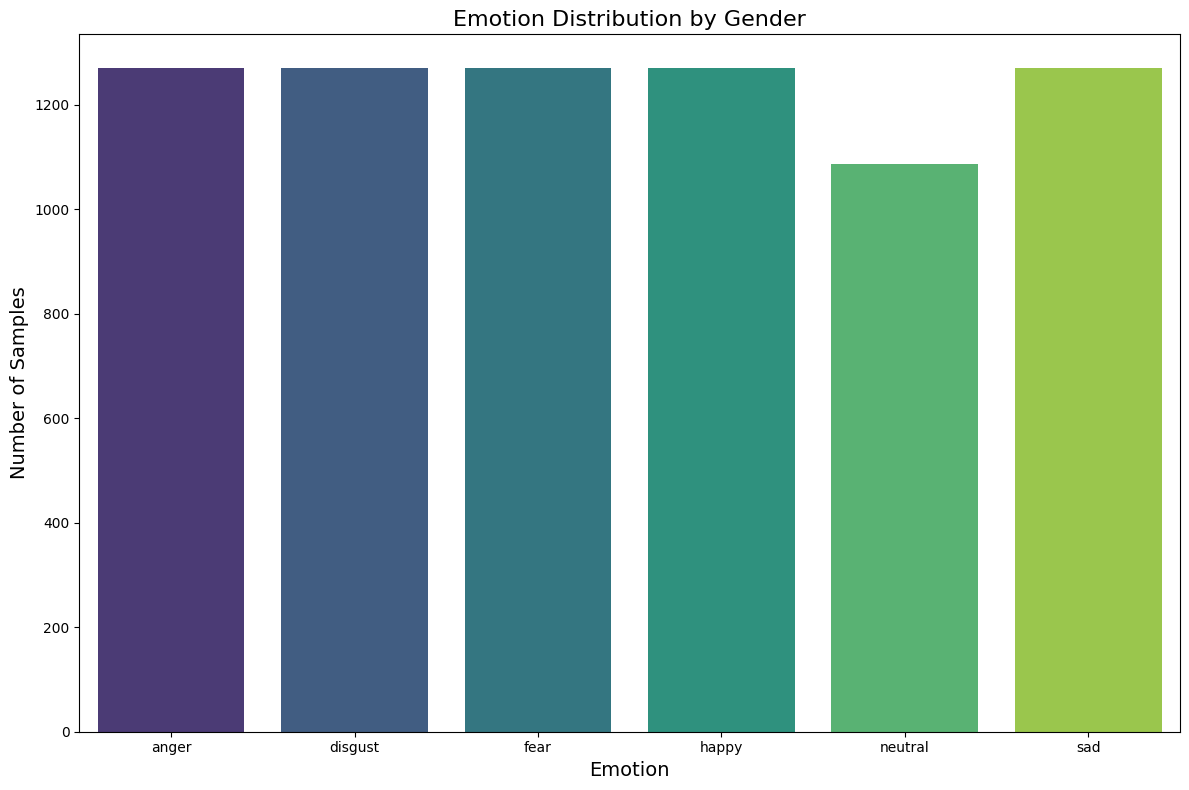

C:\Users\10\AppData\Local\Temp\ipykernel_22340\649401728.py:4: RuntimeWarning: divide by zero encountered in divide
  X = X / np.max(X)
C:\Users\10\AppData\Local\Temp\ipykernel_22340\649401728.py:4: RuntimeWarning: invalid value encountered in divide
  X = X / np.max(X)
c:\Users\10\anaconda3\envs\conda_venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 245ms/step - accuracy: 0.1634 - loss: 1.7915 - val_accuracy: 0.1578 - val_loss: 1.7912
Epoch 2/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 260ms/step - accuracy: 0.1589 - loss: 1.7903 - val_accuracy: 0.1578 - val_loss: 1.7912
Epoch 3/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 249ms/step - accuracy: 0.1710 - loss: 1.7899 - val_accuracy: 0.1578 - val_loss: 1.7913
Epoch 4/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 46s 248ms/step - accuracy: 0.1787 - loss: 1.7894 - val_accuracy: 0.1605 - val_loss: 1.7914
Epoch 5/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 256ms/step - accuracy: 0.1674 - loss: 1.7905 - val_accuracy: 0.1605 - val_loss: 1.7914
Epoch 6/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 256ms/step - accuracy: 0.1743 - loss: 1.7895 - val_accuracy: 0.1605 - val_loss: 1.7913
Epoch 7/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 250ms/step - accuracy: 0.1684 - loss: 1.7907 - val_accuracy: 0.1605 - val_loss: 1.7914
Epoch 8/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 46s 247ms/step - accuracy: 0.1716 - loss: 1

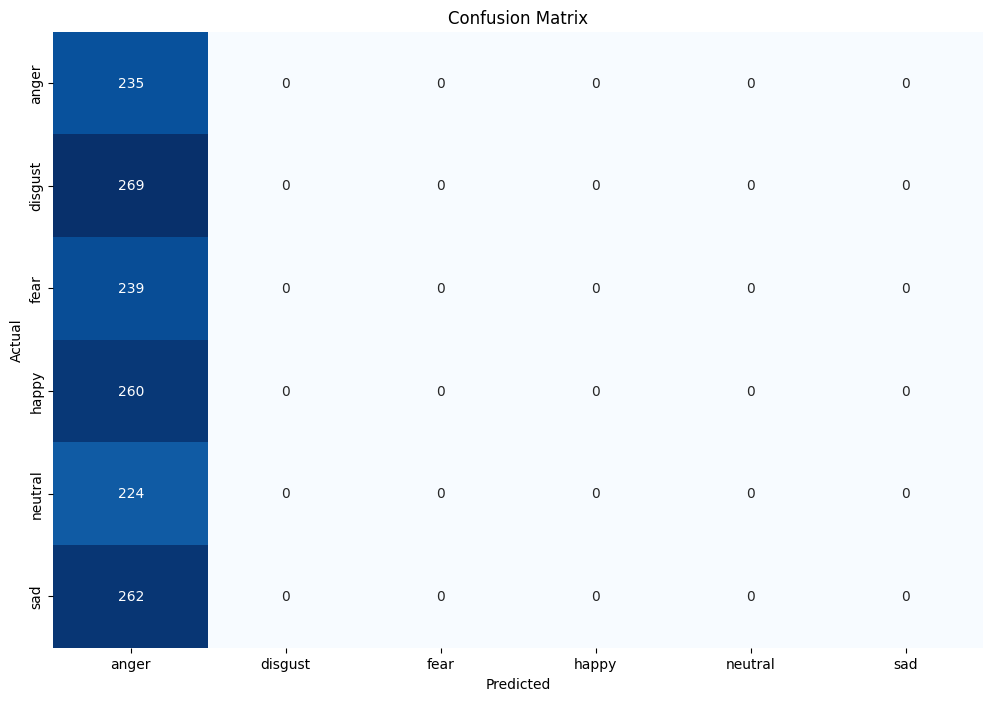

              precision    recall  f1-score   support

       anger       0.16      1.00      0.27       235
     disgust       0.00      0.00      0.00       269
        fear       0.00      0.00      0.00       239
       happy       0.00      0.00      0.00       260
     neutral       0.00      0.00      0.00       224
         sad       0.00      0.00      0.00       262

    accuracy                           0.16      1489
   macro avg       0.03      0.17      0.05      1489
weighted avg       0.02      0.16      0.04      1489



c:\Users\10\anaconda3\envs\conda_venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\10\anaconda3\envs\conda_venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\10\anaconda3\envs\conda_venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


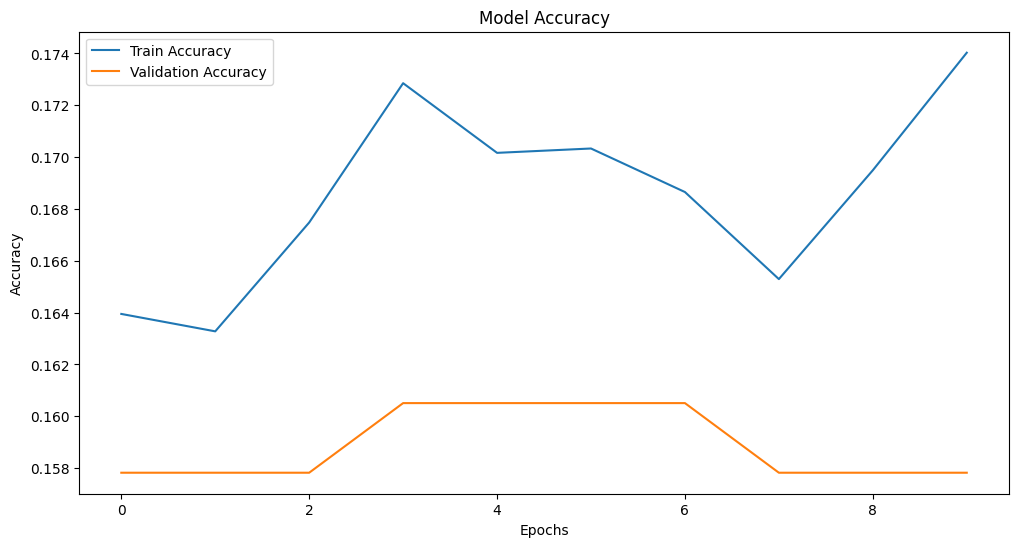

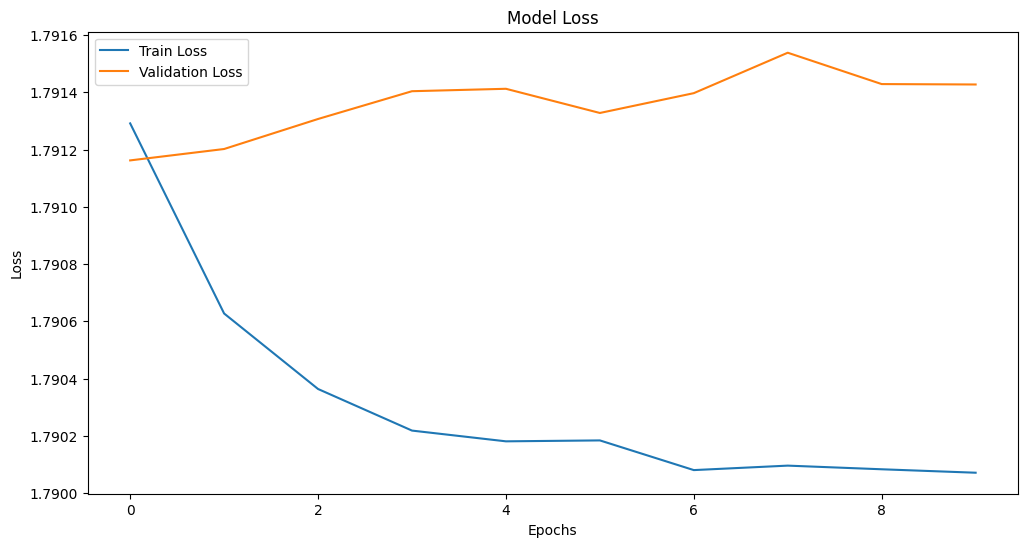

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.1672 - loss: 1.7932


Test Accuracy: 15.78%


In [9]:
def main():
    CREMA_df = load_crema_data()
    visualize_emotion_distribution(CREMA_df)
    X_train, X_test, y_train, y_test, label_encoder = preprocess_data(CREMA_df)
    model = build_model(input_shape=(128, 128, 1), num_classes=y_train.shape[1])
    train_and_evaluate_model(model, X_train, y_train, X_test, y_test, X_test, y_test, label_encoder)

    model.save("../exported_files/cnn_CREMA_D.h5")
    with open("../exported_files/cnn_CREMA_D_label_encoder.pkl", "wb") as handle:
        pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)


if __name__ == "__main__":
    main()